In [1]:
import os
import logging
import glob
import shutil

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2024-04-30 17:34:27.469317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 17:34:27.499036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 17:34:27.910276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/denis/Coding/projects/PUNK-Places-Recognition-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_in

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("TensorFlow version: ", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
gpus

TensorFlow version:  2.16.1
1 Physical GPUs, 1 Logical GPUs


2024-04-30 17:34:28.528278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:34:28.550640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:34:28.550769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_path = "../data"
prep_data_path = "../prep_data"


classes = ['matmekh',
            'Shayba',
            'Dvadcatki',
            'Desyatki',
            'pmpu'
]
num_classes = len(classes)
classes

['matmekh', 'Shayba', 'Dvadcatki', 'Desyatki', 'pmpu']

In [4]:
#for cl in classes:
#    img_path = os.path.join(data_path, cl)
#    images = glob.glob(img_path + '/*.jpg')
#    print(f"{cl} : {len(images)} Images")
#    train, val, test = images[:round(len(images)*0.7)], images[round(len(images)*0.7):round(len(images)*0.85)], images[round(len(images)*0.85):]
#
#    for t in train:
#        if not os.path.exists(os.path.join(prep_data_path, 'train', cl)):
#            os.makedirs(os.path.join(prep_data_path, 'train', cl))
#        shutil.copy(t, os.path.join(prep_data_path, 'train', cl))
#
#    for v in val:
#        if not os.path.exists(os.path.join(prep_data_path, 'val', cl)):
#            os.makedirs(os.path.join(prep_data_path, 'val', cl))
#        shutil.copy(v, os.path.join(prep_data_path, 'val', cl))
#
#    for ts in train:
#        if not os.path.exists(os.path.join(prep_data_path, 'test', cl)):
#            os.makedirs(os.path.join(prep_data_path, 'test', cl))
#        shutil.copy(ts, os.path.join(prep_data_path, 'test', cl))


In [5]:
train_dir = os.path.join(prep_data_path, "train")
val_dir = os.path.join(prep_data_path, "val")
test_dir = os.path.join(prep_data_path, "test")

total_train = sum(len(os.listdir(os.path.join(train_dir, cl))) for cl in classes)
total_val = sum(len(os.listdir(os.path.join(val_dir, cl))) for cl in classes)
total_test = sum(len(os.listdir(os.path.join(test_dir, cl))) for cl in classes)


2024-04-30 17:34:29.493855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


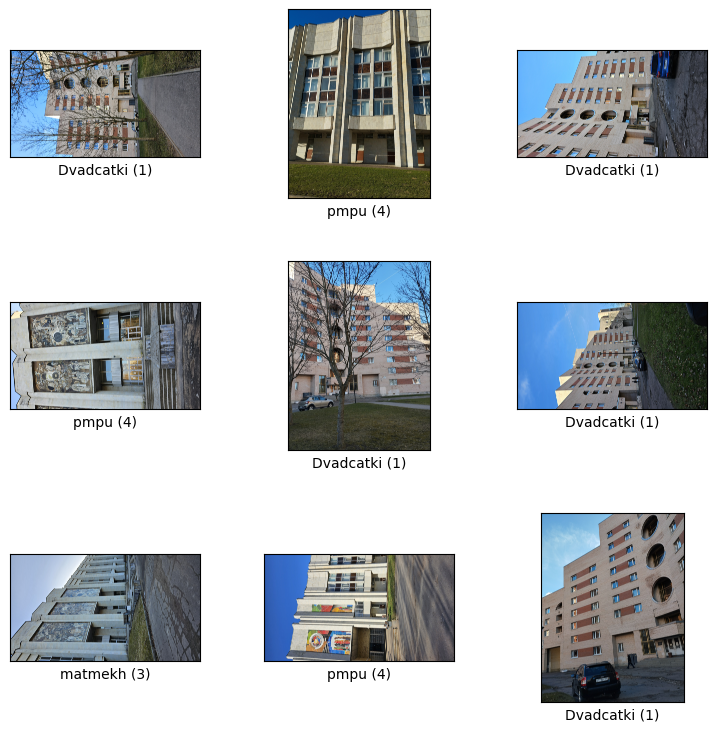

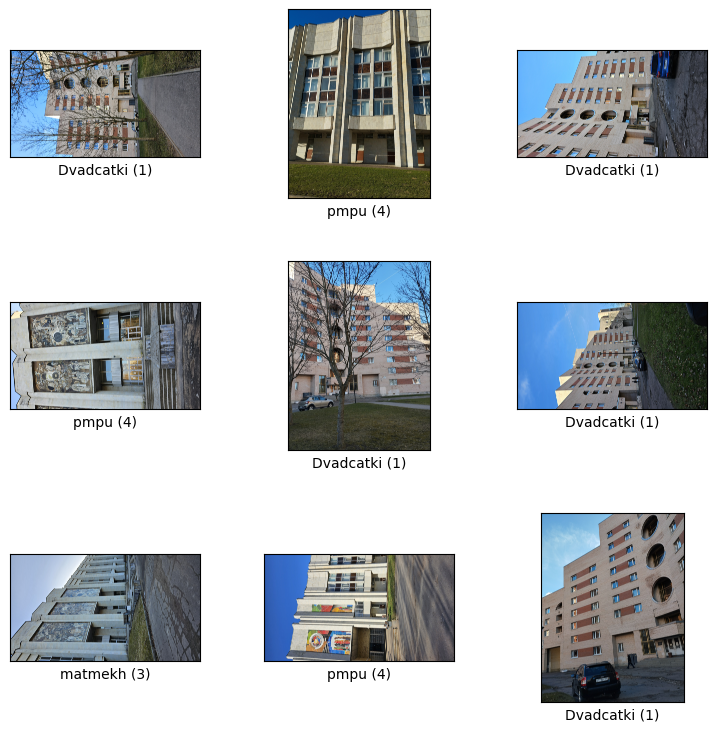

In [6]:
IMG_SHAPE = 160

builder = tfds.ImageFolder(prep_data_path, shape=(None, None, 3))

train_set = builder.as_dataset(split='train', as_supervised=True)
val_set = builder.as_dataset(split='val', as_supervised=True)
test_set = builder.as_dataset(split='test', as_supervised=True)
tfds.show_examples(train_set, builder.info)

In [7]:
def normalize_and_resize(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    image /= 255
    return image, label

train_set = train_set.map(normalize_and_resize).cache()
val_set = val_set.map(normalize_and_resize).cache()
test_set = test_set.map(normalize_and_resize).cache()

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
])

In [9]:
model = tf.keras.models.Sequential([
    layers.InputLayer(shape=(IMG_SHAPE,IMG_SHAPE,3)),
    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),
    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 915,429 (3.49 MB)

 Trainable params: 915,429 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
checkpoint_path = "../trained_models/ckpt/checkpoint.model.keras"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)

In [13]:
BATCH_SIZE = 32
EPOCHS = 20

train_set = train_set.cache().repeat().map(lambda x, y: (data_augmentation(x, training=True), y)).shuffle(total_train).batch(BATCH_SIZE)
val_set = val_set.cache().repeat().map(lambda x, y: (data_augmentation(x, training=True), y)).shuffle(total_val).batch(BATCH_SIZE)

history = model.fit(
    train_set, validation_data=val_set, batch_size=BATCH_SIZE,
    epochs=EPOCHS, steps_per_epoch=int(total_train/BATCH_SIZE), validation_steps=int(total_val/BATCH_SIZE), callbacks=[cp_callback]
)

In [14]:
model.load_weights(checkpoint_path)

test_set = test_set.cache().repeat(5).batch(32)

results = model.evaluate(test_set, batch_size=32)

/home/denis/Coding/projects/PUNK-Places-Recognition-Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-04-30 17:34:37.153619: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830656 bytes after encountering the first element of size 9830656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1714487677.155146   22320 service.cc:145] XLA service 0x73a118086390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714487677.155170   22320 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-30 17:34:37.162141: I t

  1/182 ━━━━━━━━━━━━━━━━━━━━ 4:23 1s/step - accuracy: 0.9375 - loss: 0.1598

I0000 00:00:1714487678.299559   22320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9129 - loss: 0.1851
